In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load and preprocess the image
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128)).astype(np.float32) / 255.0
    return image

image = load_image("/content/hera_pheri_Sh8DBP3.jpg")
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)

In [4]:
# U-Net architecture
class SelfAttention(nn.Module):
    """Self-attention layer for adding attention mechanism to the UNet"""
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = x.view(-1, self.channels, size[0] * size[1]).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(1, 2).view(-1, self.channels, size[0], size[1])

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=128, use_attention=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        self.norm1 = nn.GroupNorm(8, in_channels) if in_channels >= 8 else nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_channels) if out_channels >= 8 else nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.use_attention = use_attention
        self.attention = SelfAttention(out_channels) if use_attention else nn.Identity()
        self.dropout = nn.Dropout(0.1)  # dropout for regularization

    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = F.silu(h)  # SiLU (Swish) activation
        h = self.conv1(h)

        # Time conditioning
        time_emb = F.silu(t_emb)
        time_emb = self.time_mlp(time_emb)
        h = h + time_emb.unsqueeze(-1).unsqueeze(-1)

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        # attention
        if self.use_attention:
            h = self.attention(h)

        return h + self.shortcut(x)

In [6]:
class ImprovedUNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super().__init__()
        # time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # number of channels
        self.down1 = ResidualBlock(1, 64, time_emb_dim)
        self.down2 = ResidualBlock(64, 128, time_emb_dim)
        self.down3 = ResidualBlock(128, 256, time_emb_dim)
        self.down4 = ResidualBlock(256, 512, time_emb_dim, use_attention=True)  # attention layer at bottleneck

        # Middle block with attention
        self.mid1 = ResidualBlock(512, 512, time_emb_dim, use_attention=True)
        self.mid2 = ResidualBlock(512, 512, time_emb_dim, use_attention=True)

        # Upsample blocks
        self.up1 = ResidualBlock(512 + 512, 256, time_emb_dim, use_attention=True)
        self.up2 = ResidualBlock(256 + 256, 128, time_emb_dim)
        self.up3 = ResidualBlock(128 + 128, 64, time_emb_dim)
        self.up4 = ResidualBlock(64 + 64, 64, time_emb_dim)

        # Final layers
        self.norm_final = nn.GroupNorm(8, 64)
        self.conv_final = nn.Conv2d(64, 1, 1)

        # Downsample and upsample operations
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t.view(-1, 1))

        # Downsample path with skip connections
        x1 = self.down1(x, t_emb)
        x = self.downsample(x1)

        x2 = self.down2(x, t_emb)
        x = self.downsample(x2)

        x3 = self.down3(x, t_emb)
        x = self.downsample(x3)

        x4 = self.down4(x, t_emb)
        x = self.downsample(x4)

        # Middle blocks
        x = self.mid1(x, t_emb)
        x = self.mid2(x, t_emb)

        # Upsample path with skip connections
        x = self.upsample(x)
        x = torch.cat([x, x4], dim=1)
        x = self.up1(x, t_emb)

        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up2(x, t_emb)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3(x, t_emb)

        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x, t_emb)

        # Final layers
        x = self.norm_final(x)
        x = F.silu(x)
        x = self.conv_final(x)

        return x


In [7]:
# Improved diffusion hyperparameters
num_timesteps = 500  # Increased for smoother transitions
beta_start = 1e-5    # Lower start value for more gradual noise addition
beta_end = 0.01      # Lower end value for less extreme noise at the end

In [8]:
# Cosine noise schedule (from improved DDPM paper)
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    if schedule_name == "cosine":
        # Cosine schedule as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
        steps = num_diffusion_timesteps + 1
        x = torch.linspace(0, num_diffusion_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_diffusion_timesteps) + 0.008) / 1.008 * np.pi / 2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)
    elif schedule_name == "linear":
        return torch.linspace(beta_start, beta_end, num_diffusion_timesteps)
    else:
        raise ValueError(f"Unknown beta schedule: {schedule_name}")

In [9]:
# cosine schedule
betas = get_named_beta_schedule("cosine", num_timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1 - alphas_cumprod)
posterior_mean_coef2 = (1 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - alphas_cumprod)

In [10]:
# Forward diffusion process
def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    x_t = sqrt_alphas_cumprod[t] * x_0 + sqrt_one_minus_alphas_cumprod[t] * noise
    return x_t, noise

In [11]:
# training data with improved sampling
def create_training_data(image_tensor, num_samples=1000):
    batch_size = image_tensor.shape[0]
    for _ in range(num_samples // batch_size):
        # Sample random timesteps with emphasis on earlier and later steps
        # This helps the model learn both high-frequency and low-frequency details
        weights = torch.ones(num_timesteps)
        weights[:num_timesteps//4] = 2.0  # More emphasis on early timesteps
        weights[3*num_timesteps//4:] = 2.0  # More emphasis on late timesteps
        t = torch.multinomial(weights, batch_size, replacement=True).to(device)

        # Add noise according to the timesteps
        x_t, noise = forward_diffusion(image_tensor, t)
        yield x_t, noise, t

In [12]:
# Create model and optimizer
model = ImprovedUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)  # AdamW with weight decay

In [13]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=75, eta_min=1e-6)

In [14]:
# EMA model for better sampling results
class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    self.decay * self.shadow[name].data + (1 - self.decay) * param.data
                )

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name].data.clone()

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name].data.clone()

In [15]:
# Initialize EMA
ema = EMA(model)

In [16]:
# Mixed precision training setup
scaler = GradScaler()

<ipython-input-16-0da28500c240>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [17]:
# training loop with gradient clipping
def train_model(model, image_tensor, num_epochs=100, samples_per_epoch=500):
    best_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0
        data_generator = create_training_data(image_tensor, samples_per_epoch)

        for x_t, target_noise, t in tqdm(data_generator, desc=f"Epoch {epoch+1}", total=samples_per_epoch//image_tensor.shape[0]):
            optimizer.zero_grad()

            # mixed precision for faster training
            with autocast():
                # Predict noise
                predicted_noise = model(x_t, t.float() / num_timesteps)

                # MSE loss between predicted and target noise
                loss = F.mse_loss(predicted_noise, target_noise)

            # Scale gradients and backprop
            scaler.scale(loss).backward()

            # Gradient clipping for stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update weights
            scaler.step(optimizer)
            scaler.update()

            # Update EMA model
            ema.update()

            total_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        avg_loss = total_loss / (samples_per_epoch // image_tensor.shape[0])
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6e}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'ema_shadow': ema.shadow,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_diffusion_model.pth')
            print(f"Model saved with loss: {best_loss:.6f}")

        # Visualize generation with EMA model every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Apply EMA weights
            ema.apply_shadow()
            # Sample with DDIM for faster, better quality
            sample_ddim(model)
            # Restore original weights
            ema.restore()

In [18]:
# DDIM sampling for improved quality
@torch.no_grad()
def sample_ddim(model, batch_size=1, save_intermediate=True, eta=0.0, subset_timesteps=100):
    # Subsample timesteps for faster, high-quality sampling (DDIM)
    skip = num_timesteps // subset_timesteps
    timesteps = torch.arange(0, num_timesteps, skip)

    # Start with pure noise
    x = torch.randn(batch_size, 1, 128, 128).to(device)

    intermediate_steps = []
    if save_intermediate:
        intermediate_steps.append(x.cpu().squeeze().numpy())

    # Reverse diffusion with DDIM
    for i in tqdm(range(len(timesteps)-1, -1, -1), desc="DDIM Sampling"):
        t = timesteps[i]
        t_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t

        # Predict noise
        predicted_noise = model(x, t_tensor.float() / num_timesteps)

        if i > 0:
            next_t = timesteps[i-1]
        else:
            next_t = 0

        # DDIM deterministic sampling formula
        alpha_cumprod_t = alphas_cumprod[t]
        alpha_cumprod_next_t = alphas_cumprod[next_t]

        # Compute x0 from xt and predicted noise
        x0_pred = (x - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]

        # Clip predicted x0 for stability
        x0_pred = torch.clamp(x0_pred, -1, 1)

        # DDIM formula: interpolate between deterministic and stochastic paths
        # eta = 0 (deterministic) to 1 (stochastic like DDPM)
        eps = predicted_noise
        if eta > 0:
            # Add randomness if eta > 0
            random_noise = torch.randn_like(x)
            sigma_t = eta * torch.sqrt((1 - alpha_cumprod_next_t) / (1 - alpha_cumprod_t)
                                      * (1 - alpha_cumprod_t / alpha_cumprod_next_t))
        else:
            # Fully deterministic
            sigma_t = 0
            random_noise = 0

        # DDIM update step
        c1 = torch.sqrt(alpha_cumprod_next_t)
        c2 = torch.sqrt(1 - alpha_cumprod_next_t - sigma_t**2)
        x = c1 * x0_pred + c2 * eps + sigma_t * random_noise

        if save_intermediate and (i % max(len(timesteps) // 10, 1) == 0 or i == len(timesteps) - 1):
            # min-max scaling to display nicer images
            img_to_save = x.cpu().squeeze().numpy()
            img_min, img_max = img_to_save.min(), img_to_save.max()
            if img_max > img_min:
                img_to_save = (img_to_save - img_min) / (img_max - img_min)
            intermediate_steps.append(img_to_save)

    # Visualize the reverse diffusion process
    if save_intermediate:
        plt.figure(figsize=(15, 5))
        for i, img in enumerate(intermediate_steps):
            plt.subplot(1, len(intermediate_steps), i + 1)
            plt.imshow(np.clip(img, 0, 1), cmap='gray')
            plt.title(f"Step {i}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Normalize output to [0,1]
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)

    return x

Starting training...


Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-17-5822e7e22dc6>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]


Epoch 1, Average Loss: 0.095789, LR: 9.995658e-05
Model saved with loss: 0.095789


Epoch 2: 100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Epoch 2, Average Loss: 0.045475, LR: 9.982640e-05
Model saved with loss: 0.045475


Epoch 3: 100%|██████████| 1000/1000 [00:53<00:00, 18.76it/s]


Epoch 3, Average Loss: 0.039890, LR: 9.960968e-05
Model saved with loss: 0.039890


Epoch 4: 100%|██████████| 1000/1000 [00:53<00:00, 18.57it/s]


Epoch 4, Average Loss: 0.032862, LR: 9.930680e-05
Model saved with loss: 0.032862


Epoch 5: 100%|██████████| 1000/1000 [00:55<00:00, 18.15it/s]


Epoch 5, Average Loss: 0.031352, LR: 9.891831e-05
Model saved with loss: 0.031352


Epoch 6: 100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]


Epoch 6, Average Loss: 0.025737, LR: 9.844487e-05
Model saved with loss: 0.025737


Epoch 7: 100%|██████████| 1000/1000 [00:53<00:00, 18.71it/s]


Epoch 7, Average Loss: 0.024604, LR: 9.788732e-05
Model saved with loss: 0.024604


Epoch 8: 100%|██████████| 1000/1000 [00:52<00:00, 18.90it/s]


Epoch 8, Average Loss: 0.021480, LR: 9.724663e-05
Model saved with loss: 0.021480


Epoch 9: 100%|██████████| 1000/1000 [00:53<00:00, 18.70it/s]


Epoch 9, Average Loss: 0.019071, LR: 9.652394e-05
Model saved with loss: 0.019071


Epoch 10: 100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


Epoch 10, Average Loss: 0.019421, LR: 9.572050e-05


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 95.00it/s]


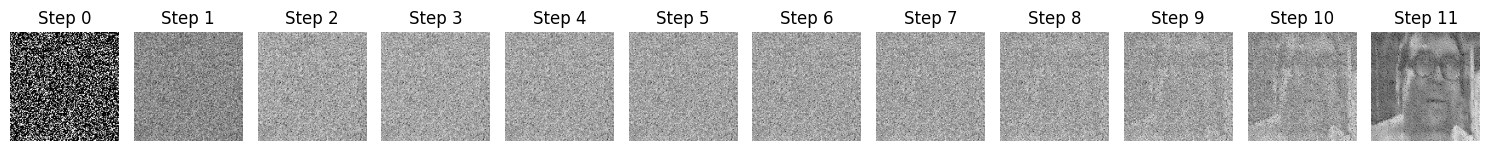

Epoch 11: 100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


Epoch 11, Average Loss: 0.017215, LR: 9.483773e-05
Model saved with loss: 0.017215


Epoch 12: 100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


Epoch 12, Average Loss: 0.016362, LR: 9.387718e-05
Model saved with loss: 0.016362


Epoch 13: 100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


Epoch 13, Average Loss: 0.018254, LR: 9.284053e-05


Epoch 14: 100%|██████████| 1000/1000 [00:54<00:00, 18.20it/s]


Epoch 14, Average Loss: 0.012955, LR: 9.172960e-05
Model saved with loss: 0.012955


Epoch 15: 100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


Epoch 15, Average Loss: 0.015359, LR: 9.054634e-05


Epoch 16: 100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]


Epoch 16, Average Loss: 0.013602, LR: 8.929283e-05


Epoch 17: 100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


Epoch 17, Average Loss: 0.011462, LR: 8.797126e-05
Model saved with loss: 0.011462


Epoch 18: 100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


Epoch 18, Average Loss: 0.009298, LR: 8.658395e-05
Model saved with loss: 0.009298


Epoch 19: 100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


Epoch 19, Average Loss: 0.012652, LR: 8.513334e-05


Epoch 20: 100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


Epoch 20, Average Loss: 0.013974, LR: 8.362197e-05


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 73.93it/s]


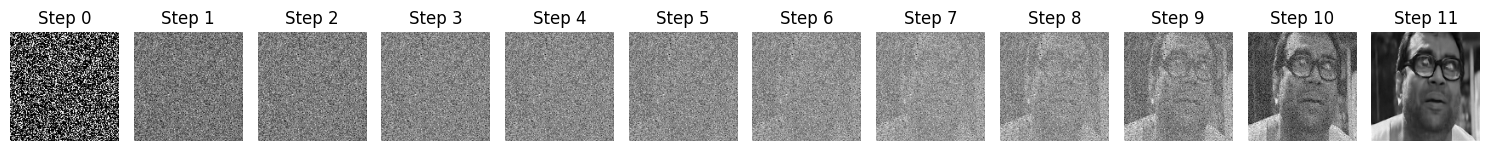

Epoch 21: 100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


Epoch 21, Average Loss: 0.010089, LR: 8.205249e-05


Epoch 22: 100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


Epoch 22, Average Loss: 0.010303, LR: 8.042766e-05


Epoch 23: 100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


Epoch 23, Average Loss: 0.009130, LR: 7.875032e-05
Model saved with loss: 0.009130


Epoch 24: 100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


Epoch 24, Average Loss: 0.010104, LR: 7.702343e-05


Epoch 25: 100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


Epoch 25, Average Loss: 0.009255, LR: 7.525000e-05


Epoch 26: 100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


Epoch 26, Average Loss: 0.006871, LR: 7.343315e-05
Model saved with loss: 0.006871


Epoch 27: 100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


Epoch 27, Average Loss: 0.008504, LR: 7.157607e-05


Epoch 28: 100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


Epoch 28, Average Loss: 0.005909, LR: 6.968202e-05
Model saved with loss: 0.005909


Epoch 29: 100%|██████████| 1000/1000 [00:55<00:00, 18.05it/s]


Epoch 29, Average Loss: 0.007395, LR: 6.775432e-05


Epoch 30: 100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


Epoch 30, Average Loss: 0.007876, LR: 6.579634e-05


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 94.53it/s]


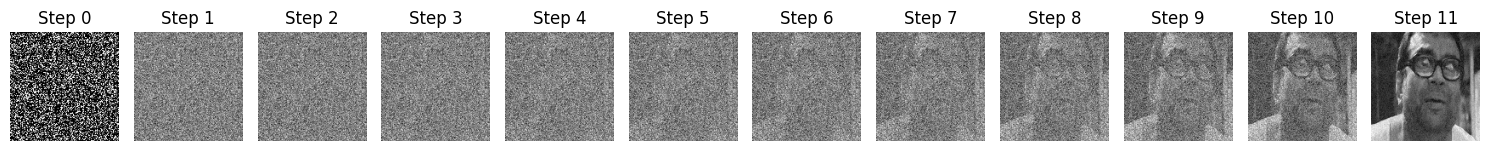

Epoch 31: 100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


Epoch 31, Average Loss: 0.005927, LR: 6.381153e-05


Epoch 32: 100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


Epoch 32, Average Loss: 0.006955, LR: 6.180337e-05


Epoch 33: 100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


Epoch 33, Average Loss: 0.006782, LR: 5.977538e-05


Epoch 34: 100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


Epoch 34, Average Loss: 0.007451, LR: 5.773111e-05


Epoch 35: 100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


Epoch 35, Average Loss: 0.006279, LR: 5.567416e-05


Epoch 36: 100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


Epoch 36, Average Loss: 0.005742, LR: 5.360813e-05
Model saved with loss: 0.005742


Epoch 37: 100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


Epoch 37, Average Loss: 0.006199, LR: 5.153665e-05


Epoch 38: 100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


Epoch 38, Average Loss: 0.006700, LR: 4.946335e-05


Epoch 39: 100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


Epoch 39, Average Loss: 0.004796, LR: 4.739187e-05
Model saved with loss: 0.004796


Epoch 40: 100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


Epoch 40, Average Loss: 0.006300, LR: 4.532584e-05


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 93.31it/s]


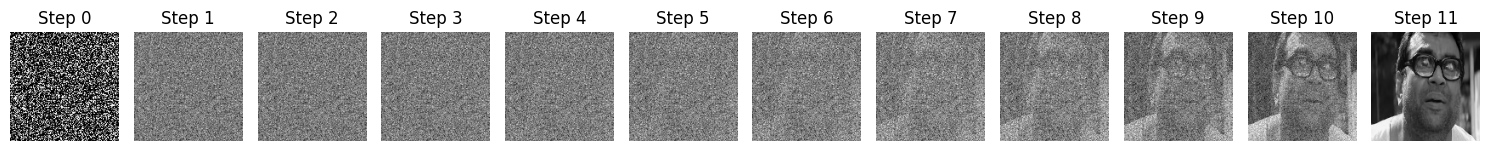

Epoch 41: 100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


Epoch 41, Average Loss: 0.005150, LR: 4.326889e-05


Epoch 42: 100%|██████████| 1000/1000 [00:58<00:00, 17.11it/s]


Epoch 42, Average Loss: 0.005199, LR: 4.122462e-05


Epoch 43: 100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


Epoch 43, Average Loss: 0.004567, LR: 3.919663e-05
Model saved with loss: 0.004567


Epoch 44: 100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


Epoch 44, Average Loss: 0.003590, LR: 3.718847e-05
Model saved with loss: 0.003590


Epoch 45: 100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


Epoch 45, Average Loss: 0.005571, LR: 3.520366e-05


Epoch 46: 100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


Epoch 46, Average Loss: 0.005721, LR: 3.324568e-05


Epoch 47: 100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


Epoch 47, Average Loss: 0.004888, LR: 3.131798e-05


Epoch 48: 100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


Epoch 48, Average Loss: 0.004256, LR: 2.942393e-05


Epoch 49: 100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


Epoch 49, Average Loss: 0.004797, LR: 2.756685e-05


Epoch 50: 100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


Epoch 50, Average Loss: 0.003819, LR: 2.575000e-05


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 91.88it/s]


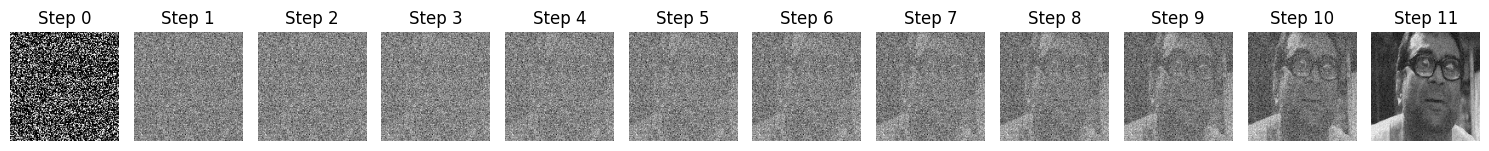

In [19]:
# Main execution
print("Starting training...")
train_model(model, img_tensor, num_epochs=50, samples_per_epoch=1000)


Generating final sample...


DDIM Sampling: 100%|██████████| 100/100 [00:01<00:00, 75.98it/s]


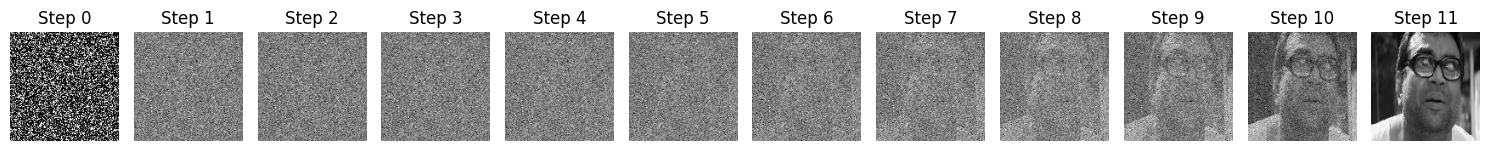

In [20]:
print("\nGenerating final sample...")
# EMA weights for final sampling
ema.apply_shadow()
# full DDIM sampling for best quality
generated_image = sample_ddim(model, eta=0.1)  # Slight randomness for better details

In [21]:
# small amount of post-processing to sharpen details
generated_np = generated_image.cpu().squeeze().numpy()
sharpened = cv2.GaussianBlur(generated_np, (0, 0), 3)
sharpened = cv2.addWeighted(generated_np, 1.5, sharpened, -0.5, 0)
sharpened = np.clip(sharpened, 0, 1)

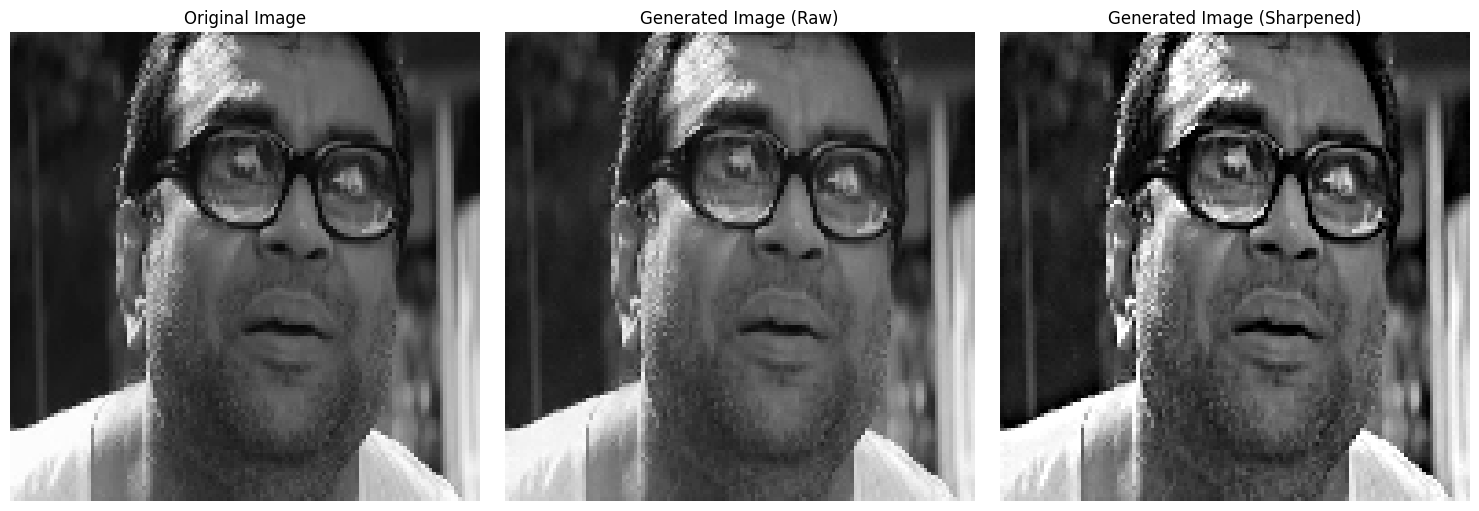

In [22]:
# Compare original and generated
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_np, cmap='gray')
plt.title("Generated Image (Raw)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sharpened, cmap='gray')
plt.title("Generated Image (Sharpened)")
plt.axis('off')

plt.tight_layout()
plt.show()